In [12]:
# ============================
# IMPORTAÇÕES E CARREGAMENTO DO DATASET
# ============================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Carregar o CSV
path = r"C:\Users\emily\OneDrive\Desktop\train.csv"
df = pd.read_csv(path)
df.head()


# ============================
# FUNÇÃO PARA CRIAR FEATURES TEMPORAIS
# ============================

def add_temporal_features(df):
    df = df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["hora"] = df["datetime"].dt.hour
    df["dia_da_semana"] = df["datetime"].dt.weekday
    df["mes"] = df["datetime"].dt.month
    df["ano"] = df["datetime"].dt.year

    # Transformações cíclicas (hora e mês)
    df["hora_sin"] = np.sin(2 * np.pi * df["hora"] / 24)
    df["hora_cos"] = np.cos(2 * np.pi * df["hora"] / 24)
    df["mes_sin"] = np.sin(2 * np.pi * df["mes"] / 12)
    df["mes_cos"] = np.cos(2 * np.pi * df["mes"] / 12)

    return df


# ============================
# CRIAÇÃO DO DATASET COMPLETO
# ============================

df_full = add_temporal_features(df)

df_full["count_log"] = np.log1p(df_full["count"])  # transformação do alvo

X = df_full.drop(columns=["count", "count_log", "casual", "registered", "datetime"])
y = df_full["count_log"]

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns


# ============================
# PIPELINE COMPLETO
# ============================

numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessamento", preprocessor),
    ("modelo", RandomForestRegressor(random_state=42))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Treinar
pipeline.fit(X_train, y_train)

# Predição em log
pred_log = pipeline.predict(X_test)

# Converter para escala real
pred = np.expm1(pred_log)
y_test_real = np.expm1(y_test)




In [13]:
baseline_cols = ["season", "holiday", "weather", "temp", "humidity", "windspeed"]

df_baseline = df[baseline_cols + ["count"]].copy()
df_baseline = df_baseline.dropna()

# LabelEncoder só para as categóricas
le = LabelEncoder()
for col in ["season", "holiday", "weather"]:
    df_baseline[col] = le.fit_transform(df_baseline[col].astype(str))

X = df_baseline[baseline_cols]
y = df_baseline["count"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

modelo_baseline = RandomForestRegressor(random_state=42)
modelo_baseline.fit(X_train, y_train)

pred = modelo_baseline.predict(X_test)
rmsle_baseline = np.sqrt(mean_squared_log_error(y_test, pred))
rmsle_baseline


np.float64(1.2687325189956282)

In [14]:
def add_temporal_features(df):
    df = df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])

    df["hora"] = df["datetime"].dt.hour
    df["dia_semana"] = df["datetime"].dt.weekday
    df["mes"] = df["datetime"].dt.month
    df["ano"] = df["datetime"].dt.year

    df["hora_sin"] = np.sin(2 * np.pi * df["hora"] / 24)
    df["hora_cos"] = np.cos(2 * np.pi * df["hora"] / 24)

    df["mes_sin"] = np.sin(2 * np.pi * df["mes"] / 12)
    df["mes_cos"] = np.cos(2 * np.pi * df["mes"] / 12)

    return df


In [15]:
df_full = add_temporal_features(df)

df_full["count_log"] = np.log1p(df_full["count"])  # transformação do alvo

X = df_full.drop(columns=["count", "count_log", "casual", "registered", "datetime"])
y = df_full["count_log"]

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

pred_log = pipeline.predict(X_test)
pred = np.expm1(pred_log)
y_true = np.expm1(y_test)

rmsle_pipeline = np.sqrt(mean_squared_log_error(y_true, pred))
rmsle_pipeline


np.float64(0.30204957101849395)

In [16]:
print("RMSLE Baseline: ", rmsle_baseline)
print("RMSLE Pipeline:", rmsle_pipeline)

melhoria = (rmsle_baseline - rmsle_pipeline) / rmsle_baseline * 100
print(f"Melhoria percentual: {melhoria:.2f}%")


RMSLE Baseline:  1.2687325189956282
RMSLE Pipeline: 0.30204957101849395
Melhoria percentual: 76.19%


In [17]:
pipeline.fit(X_train, y_train)

pred_log = pipeline.predict(X_test)
pred = np.expm1(pred_log)
y_true = np.expm1(y_test)

rmsle_pipeline = np.sqrt(mean_squared_log_error(y_true, pred))
rmsle_pipeline


np.float64(0.30204957101849395)

In [18]:
print("RMSLE Baseline:", rmsle_baseline)
print("RMSLE Pipeline:", rmsle_pipeline)

melhoria = (rmsle_baseline - rmsle_pipeline) / rmsle_baseline * 100
print(f"Melhoria percentual: {melhoria:.2f}%")


RMSLE Baseline: 1.2687325189956282
RMSLE Pipeline: 0.30204957101849395
Melhoria percentual: 76.19%


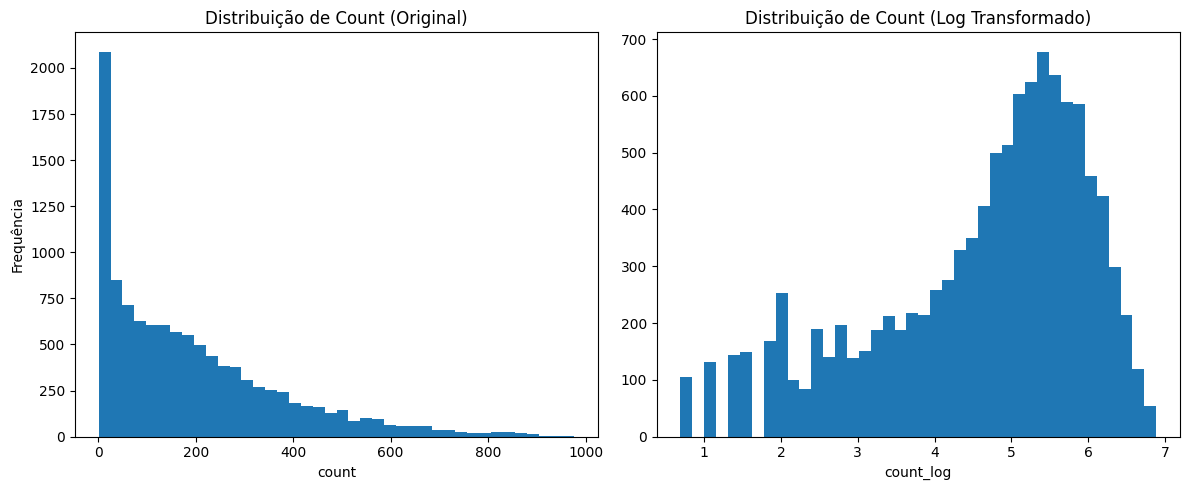

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df["count"], bins=40)
plt.title("Distribuição de Count (Original)")
plt.xlabel("count")
plt.ylabel("Frequência")

plt.subplot(1,2,2)
plt.hist(df_full["count_log"], bins=40)
plt.title("Distribuição de Count (Log Transformado)")
plt.xlabel("count_log")

plt.tight_layout()
plt.show()


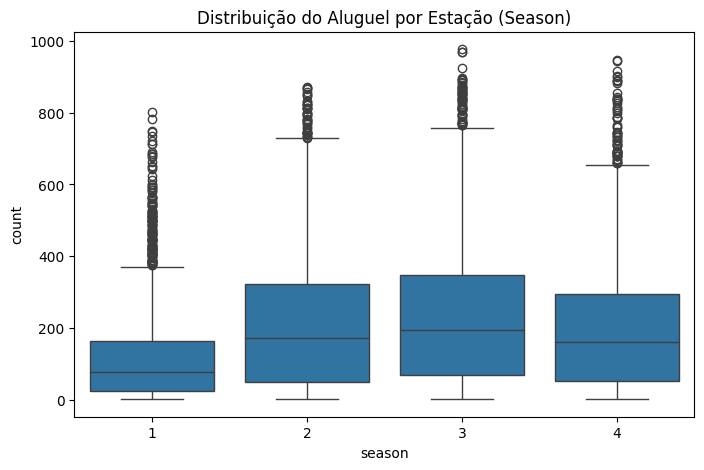

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_full, x="season", y="count")
plt.title("Distribuição do Aluguel por Estação (Season)")
plt.show()


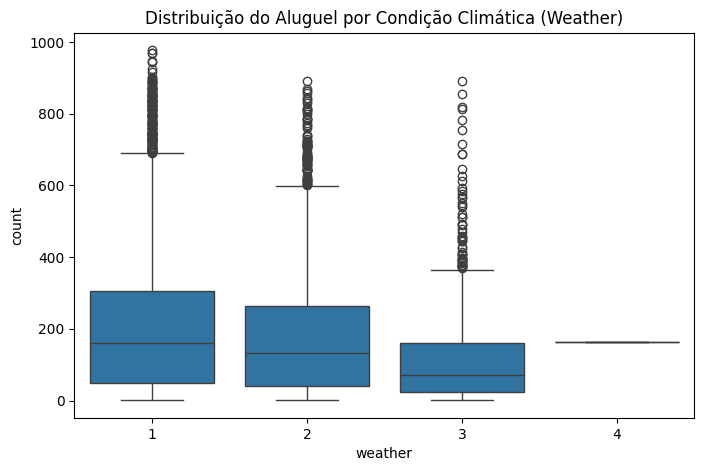

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_full, x="weather", y="count")
plt.title("Distribuição do Aluguel por Condição Climática (Weather)")
plt.show()


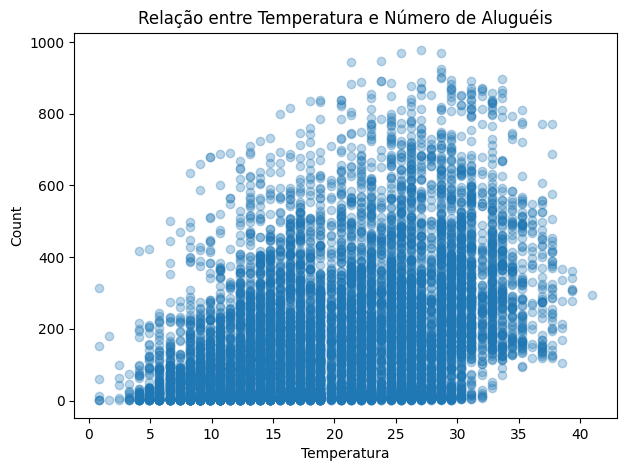

In [22]:
plt.figure(figsize=(7,5))
plt.scatter(df_full["temp"], df_full["count"], alpha=0.3)
plt.title("Relação entre Temperatura e Número de Aluguéis")
plt.xlabel("Temperatura")
plt.ylabel("Count")
plt.show()


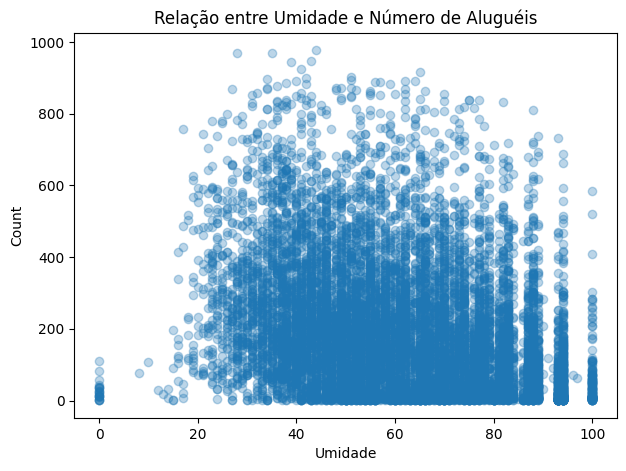

In [23]:
plt.figure(figsize=(7,5))
plt.scatter(df_full["humidity"], df_full["count"], alpha=0.3)
plt.title("Relação entre Umidade e Número de Aluguéis")
plt.xlabel("Umidade")
plt.ylabel("Count")
plt.show()


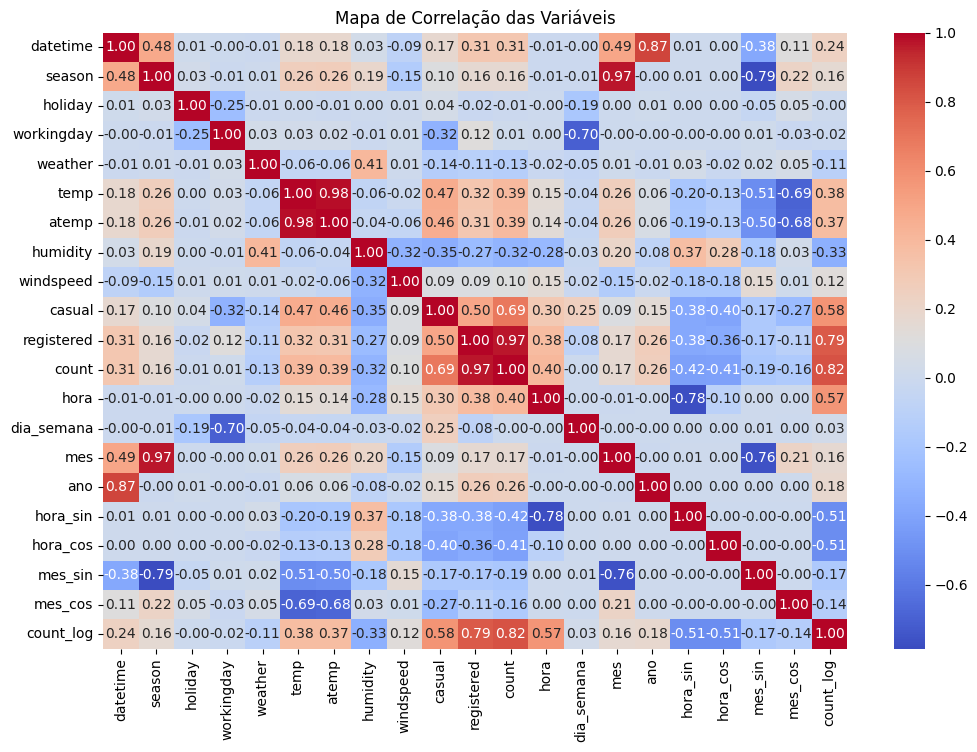

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(df_full.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Mapa de Correlação das Variáveis")
plt.show()


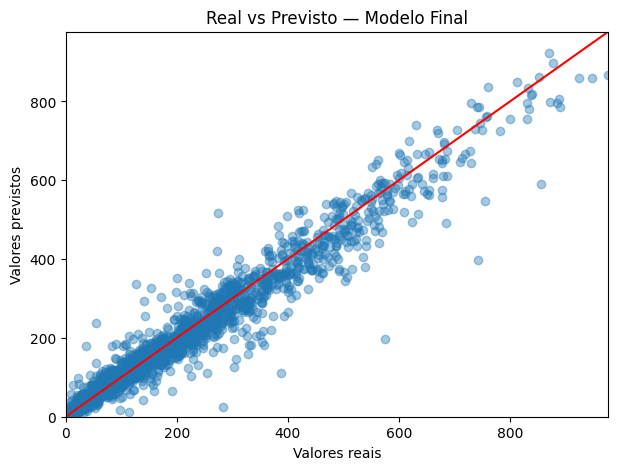

In [25]:
plt.figure(figsize=(7,5))
plt.scatter(y_test_real, pred, alpha=0.4)
plt.xlabel("Valores reais")
plt.ylabel("Valores previstos")
plt.title("Real vs Previsto — Modelo Final")

mx = max(np.max(y_test_real), np.max(pred))
plt.plot([0, mx], [0, mx], color="red")
plt.xlim(0, mx)
plt.ylim(0, mx)
plt.show()

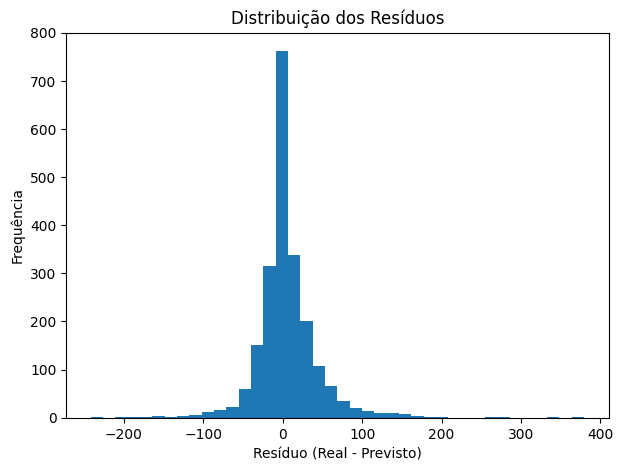

In [26]:
residuos = y_test_real - pred

plt.figure(figsize=(7,5))
plt.hist(residuos, bins=40)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduo (Real - Previsto)")
plt.ylabel("Frequência")
plt.show()
